# Create & deploy a Deep learning model into WML for Image Classification

#### *This model uses sample data from the original yoga postures data. The sample data has 31 images across four categories for training, 8 images across four categories for validation & 4 images across four images for testing. This is to demonstrate the methodology to create and deploy a Keras model to WML.*

### Install specified versions of the deep learning frameworks

In [1]:
!pip install ibm-cos-sdk
!pip install 'keras==2.2.4' --force-reinstall
!pip install 'tensorflow==1.5' --force-reinstall

Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: ibm-cos-sdk-s3transfer==2.*,>=2.0.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk)
Requirement not upgraded as not directly required: ibm-cos-sdk-core==2.*,>=2.0.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk)
Requirement not upgraded as not directly required: docutils>=0.10 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk)
Requirement not upgraded as not directly required: jmespath<1.0.0,>=0.7.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk)
Requirement not upgraded as not directly required: python-dateutil<3.0.0,>=2.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk)
Re

## Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import ibm_boto3
from botocore.client import Config

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


 #### *Sample images data has been resized to 32 x 32 pixels & converted to numpy array and class has been assigned per below. The data has been reformated & pickled to be consumed by the Watson Machine Learning Model.*

In [3]:
import pandas as pd 
   
source_data = [['balasana', 0], ['garudasana', 1], ['marichyasana', 2], ['padangusthasana', 3]]  
df = pd.DataFrame(source_data, columns = ['Posture_name', 'Class']) 
df

,Posture_name,Class
0,balasana,0
1,garudasana,1
2,marichyasana,2
3,padangusthasana,3


## Insert credentials for train.pkl file. Data includes 31 images for four classes

In [4]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-c783976a-e5af-4bfd-9670-640ada880dd0',
    'IBM_API_KEY_ID': 'aZ-GYGb4c2piE_VEtAqTHkBE5aY9qZyzRWzyUIe350Mw',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'dstacompetition-donotdelete-pr-bhk4jxl6630u8c',
    'FILE': 'train.pkl'
}

In [5]:
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

## Download the file from cloud object storage

In [6]:
cos.download_file(Bucket=credentials['BUCKET'],Key='train.pkl',Filename='/home/dsxuser/work/train.pkl')

## Set working directory

In [7]:
cd '/home/dsxuser/work/'

/home/dsxuser/work


## Unpickle the file

In [8]:
import pickle

pkl_file = open('train.pkl', 'rb')

train_data = pickle.load(pkl_file)
pkl_file.close()

## Split the file to input(x) and target(y) variables

In [9]:
trainx, trainy = train_data

## Insert credentials for validation.pkl file. Data inclues 8 images for four classes

In [10]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-c783976a-e5af-4bfd-9670-640ada880dd0',
    'IBM_API_KEY_ID': 'aZ-GYGb4c2piE_VEtAqTHkBE5aY9qZyzRWzyUIe350Mw',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'dstacompetition-donotdelete-pr-bhk4jxl6630u8c',
    'FILE': 'validation.pkl'
}


## Download the file from cloud object storage

In [11]:
cos.download_file(Bucket=credentials['BUCKET'],Key='validation.pkl',Filename='/home/dsxuser/work/validation.pkl')

## Unpickle the file

In [12]:
pkl_file = open('validation.pkl', 'rb')

validation_data = pickle.load(pkl_file)
pkl_file.close()

In [13]:
valx, valy = validation_data

## Convert the target variables to categorical form

In [14]:
from keras.utils import to_categorical
trainy = to_categorical(trainy)
valy = to_categorical(valy)

## Build the model

In [15]:
print('***Building the model***')

FAST_RUN = False
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import time

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

***Building the model***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)      

## <font color=red>Run the below cell to use pre-trained model, else omit this cell. Images are to be resized to 224 x 224 pixels which is the requirement for this model.</font>

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.vgg16 import VGG16



vgg16_model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
vgg16_model.summary()
type(vgg16_model) 
model = Sequential() 
for layer in vgg16_model.layers:
    model.add(layer)
model.layers.pop()
model.summary()
for layer in model.layers: 
    layer.trainable = False
model.add(Dense(9, activation='sigmoid')) 
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Callbacks

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and if val_loss value has not decreased.

In [17]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when the accuracy does not increase for 2 steps

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

## <font color=red>Run the below cell to augment data on real time, else omit this cell</font>

In [20]:
from keras_preprocessing.image import ImageDataGenerator
augment_data = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

## Fit the Model

In [ ]:
print('***Not using data augmentation***')

start = time.time()
epochs=3 if FAST_RUN else 10
history = model.fit(trainx, trainy, batch_size=16, epochs=epochs,
    validation_data=(valx, valy),
    callbacks=callbacks
)

## <font color=red>Run the below cell only if the data is augmented, else omit this cell</font>

In [21]:
print('***Using data augmentation***')

start = time.time()
epochs=3 if FAST_RUN else 10
history = model.fit_generator(augment_data.flow(trainx, trainy, batch_size=16), epochs=epochs,
    validation_data=(valx, valy),
    steps_per_epoch=50,
    callbacks=callbacks
)

***Using data augmentation***
Epoch 1/10
50/50 [==============================] - 3s 62ms/step - loss: 1.2416 - acc: 0.4694 - val_loss: 1.7420 - val_acc: 0.3750
Epoch 2/10
50/50 [==============================] - 3s 52ms/step - loss: 0.9154 - acc: 0.6348 - val_loss: 1.7707 - val_acc: 0.5000
Epoch 3/10
50/50 [==============================] - 3s 51ms/step - loss: 0.8108 - acc: 0.6835 - val_loss: 1.2821 - val_acc: 0.3750
Epoch 4/10
50/50 [==============================] - 3s 51ms/step - loss: 0.6727 - acc: 0.7415 - val_loss: 2.7446 - val_acc: 0.3750

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
50/50 [==============================] - 3s 51ms/step - loss: 0.5488 - acc: 0.7899 - val_loss: 1.6086 - val_acc: 0.5000
Epoch 6/10
50/50 [==============================] - 3s 51ms/step - loss: 0.5012 - acc: 0.8088 - val_loss: 1.8354 - val_acc: 0.6250
Epoch 7/10
50/50 [==============================] - 3s 51ms/step - loss: 0.4780 - acc: 0.8122 - val_los

### Evaluate Model Accuracy

In [22]:
Validation_Accuracy = model.evaluate(valx, valy, 1)

8/8 [==============================] - 0s 13ms/step


In [23]:
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))

The Model Accuracy for Validation data is:  50.00%


## Virtualize Training

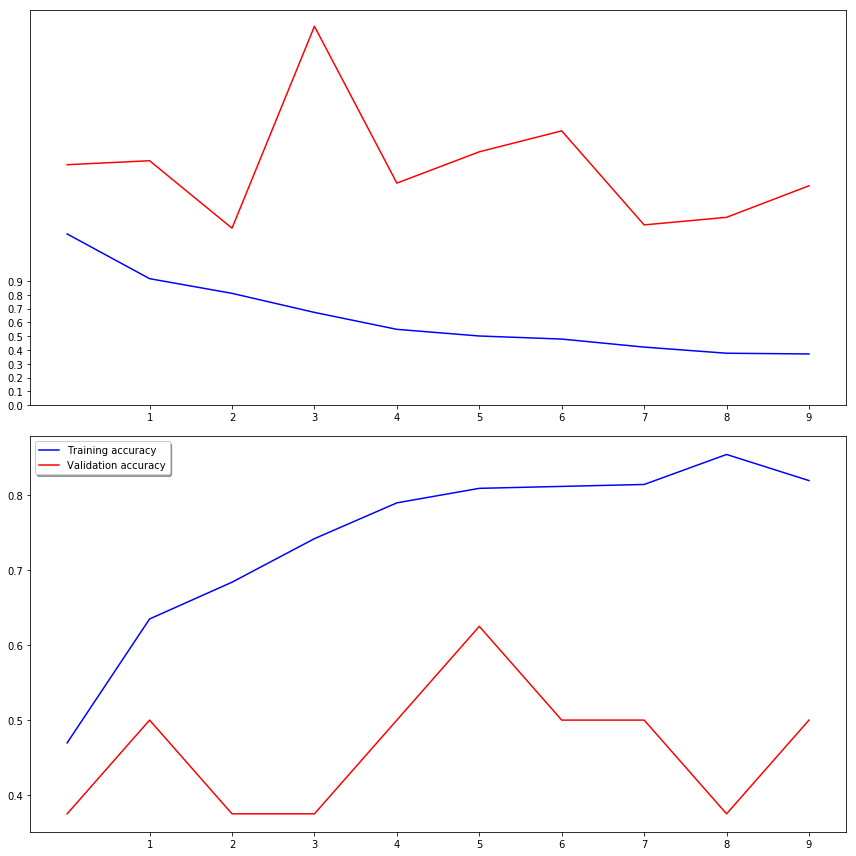

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Insert the credentials for test.pkl file. Data includes 4 images for four classes

In [25]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-c783976a-e5af-4bfd-9670-640ada880dd0',
    'IBM_API_KEY_ID': 'aZ-GYGb4c2piE_VEtAqTHkBE5aY9qZyzRWzyUIe350Mw',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'dstacompetition-donotdelete-pr-bhk4jxl6630u8c',
    'FILE': 'test.pkl'
}


In [26]:
cos.download_file(Bucket=credentials['BUCKET'],Key='test.pkl',Filename='/home/dsxuser/work/test.pkl')

## Unpickle the data

In [27]:
pkl_file = open('test.pkl', 'rb')

test_data = pickle.load(pkl_file)
pkl_file.close()

In [28]:
testx, testy = test_data

In [29]:
testy = to_categorical(testy)

## Make Predictions on test data without data augmentation

In [30]:
test_results = model.predict(testx, 1)

In [31]:
test_results = np.argmax(test_results,axis=1)
print(test_results)

[0 2 2 3]


In [32]:
orig_testy = np.argmax(testy,axis=1)
print(orig_testy)

[0 1 2 3]


## Test the accuracy

In [33]:
scores = model.evaluate(testx, testy, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', "{:.2%}".format(scores[1]))

4/4 [==============================] - 0s 15ms/step
Test loss: 1.59146881104
Test accuracy: 75.00%


## Save the model to work directory

In [34]:
model.save( "image-classification-model_new.h5" )

## Convert the model file to tgz format which is for keras model

In [35]:
!tar -zcvf image-classification-model_new.tgz image-classification-model_new.h5

image-classification-model_new.h5


## List the files in the directory

In [36]:
ls -1

image-classification-model_new.h5
image-classification-model_new.tgz
test.pkl
train.pkl
validation.pkl


## Create a Watson Machine Learning client instance

In [37]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
    "instance_id": "04e15f4f-4d93-4f86-a7fe-bfe7ec836c79",
    "password"   : "898a3c67-fc3d-445c-9175-660db346f4cf",
    "url"        : "https://us-south.ml.cloud.ibm.com",
    "username"   : "a2e75cbf-9ef2-4c61-947d-4e5ae3f1b890"
}
client = WatsonMachineLearningAPIClient( wml_credentials )

## Store the model in the Watson Machine Learning repository

In [38]:
metadata = {
    client.repository.ModelMetaNames.AUTHOR_NAME         : "Sharath Kumar RK",
    client.repository.ModelMetaNames.NAME                : "keras model",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES : [{'name':'keras', 'version': '2.2.4'}],
    client.repository.ModelMetaNames.FRAMEWORK_NAME      : "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION   : "1.5",
    client.repository.ModelMetaNames.RUNTIME_NAME        : "python",
    client.repository.ModelMetaNames.RUNTIME_VERSION     : "3.5"
    
}
model_details = client.repository.store_model( model="image-classification-model_new.tgz", meta_props=metadata )

## Deploy the stored model as an online web service deployment

In [39]:
model_id = model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_id, name="Keras deployment new" )



#######################################################################################

Synchronous deployment creation for uid: 'f90789b1-078e-493b-8de2-88e64064c7e7' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='7bd49123-30ee-46e5-80f2-c3561eeae43e'
------------------------------------------------------------------------------------------------




## Test the deployment

In [40]:
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : testx.tolist() }
client.deployments.score( model_endpoint_url, payload )

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[0.9999997615814209,
    0.003785202279686928,
    1.0587672477413435e-05,
    2.4474634301441256e-06],
   0,
   [0.9999997615814209,
    0.003785202279686928,
    1.0587672477413435e-05,
    2.4474634301441256e-06]],
  [[0.002667247550562024,
    0.008061988279223442,
    0.863553524017334,
    0.7700077295303345],
   2,
   [0.002667247550562024,
    0.008061988279223442,
    0.863553524017334,
    0.7700077295303345]],
  [[0.8332565426826477,
    0.0011062429985031486,
    0.9985122084617615,
    0.9953029155731201],
   2,
   [0.8332565426826477,
    0.0011062429985031486,
    0.9985122084617615,
    0.9953029155731201]],
  [[0.0029294812120497227, 0.00012387652532197535, 8.181531484297011e-06, 1.0],
   3,
   [0.0029294812120497227,
    0.00012387652532197535,
    8.181531484297011e-06,
    1.0]]]}

## Print the deployment URL

In [41]:
print(model_endpoint_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/04e15f4f-4d93-4f86-a7fe-bfe7ec836c79/deployments/7bd49123-30ee-46e5-80f2-c3561eeae43e/online


## Summary

#### In this notebook, we have learnt how to create & train a keras model, make predictions and evaluate the accuracy. We have also learnt how to save the model to Watson Machine Learning repository and enable online deployment for scoring.

## Author

**Sharath Kumar RK**, Data Scientist, IBM India Software Labs

## Useful links